This data was extracted from CrunchBase on December 02, 2014.
The investments series at a company level are given. The company status are given - the interesting challenge would be discover if the investments and other criteria help company to be a operating / closed / acquired stage. 

# (1) Data cleaning & exploratory data analysis (EDA) 📊

Libraries   📚

In [2]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from google.colab import drive
import glob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Loading data from files
 


We will now load a file stored in excel format with 6 sheets called crunchbase_monthly_export.xlsx 
These 6 sheets represent the information of the companies  with recorded frundasing.
The main parameters are : 

1.   company information (name,market,status,country code)
2.   Rounds 
3.   Investments 
4.   Acquisitions  



In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls "/content/drive/My Drive/umba"

crunchbase_monthly_export_d43b4klo2ade53.xlsx


In [0]:
data = pd.read_excel('/content/drive/My Drive/umba/crunchbase_monthly_export_d43b4klo2ade53.xlsx',sheet_name=None)

Definition of funtions 

In [0]:
def missing_values_table(df):   #funtion that count the missing values of a data frame 
        mis_val = df.isnull().sum()
        mis_val_percent = (100 * df.isnull().sum() / len(df))
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [0]:
def count_word(df, ref_col, liste): #funtion that count the number of words in a string 
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [0]:
def evaluate_model(X_train, X_val, y_train, y_val):
 
    model = None
 
    sequence_length = X_train.shape[1]
    filter_sizes = [3,4,5]
    num_filters = 100
    drop = 0.5
 
    inputs = Input(shape=(sequence_length,), dtype='int32')
    embedding = non_static_embedding(inputs)
    reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)
    convolution1 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu')(reshape)
    convolution2 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu')(reshape)
    convolution3 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM),activation='relu')(reshape)
    maxpooling1 = MaxPooling2D((sequence_length - filter_sizes[0]+1,1), strides=(1,1), padding = 'valid') (convolution1)
    maxpooling2 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding = 'valid')(convolution1)
    maxpooling3 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding = 'valid')(convolution1)
    merged = concatenate([maxpooling1, maxpooling2, maxpooling3], axis=1)
    flatten = Flatten()(merged)
    dropout = Dropout(drop)(flatten)
    output = Dense(units=1, activation='sigmoid', kernel_regularizer=regularizers.l2(3))(dropout)
    model = Model(inputs, output)
    epochs = 100
    batch_size = 50
    model.compile(loss='binary_crossentropy', optimizer=Adadelta(lr=1), metrics=['acc'])
    #model.save_weights('model.h5') #
    callbacks = [EarlyStopping(monitor='val_acc', patience = 10)]
    model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=epochs, batch_size=batch_size, verbose=2)#, callbacks = callbacks) 
    _, val_acc = model.evaluate(X_val, y_val, verbose = 1)
   #model.load_weights('model.h5') #
 

In [0]:
def makeCloud(Dict,name,color): #funtion to create a cloud of words 
    words = dict()

    for s in Dict:
        words[s[0]] = s[1]

        wordcloud = WordCloud(
                      width=1500,
                      height=750, 
                      background_color=color, 
                      max_words=50,
                      max_font_size=500, 
                      normalize_plurals=False)
        wordcloud.generate_from_frequencies(words)


    fig = plt.figure(figsize=(12, 8))
    plt.title(name)
    plt.imshow(wordcloud)
    plt.axis('off')

    plt.show()

TechCrunch is an American online publisher focusing on the tech industry. The company specifically reports on the business related to tech, technology news, analysis of emerging trends in tech, and profiling of new tech businesses and products. It was one of the earliest publications to report extensively on tech startups and funding. 

This nformation is from the TechCrush open data set. That describe a total of 49K companies

In [0]:
odict_keys=['Companies', 'Rounds', 'Investments', 'Acquisitions'] #names of the sheets

In [10]:
data[odict_keys[0]].head()

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1750000,acquired,USA,NY,New York City,New York,1,2012-06-01 00:00:00,2012-06,2012-Q2,2012.0,2012-06-30 00:00:00,2012-06-30 00:00:00
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,4000000,operating,USA,CA,Los Angeles,Los Angeles,2,NaN,NaN,NaN,NaN,2010-06-04 00:00:00,2010-09-23 00:00:00
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,40000,operating,EST,NaN,Tallinn,Tallinn,1,2012-10-26 00:00:00,2012-10,2012-Q4,2012.0,2012-08-09 00:00:00,2012-08-09 00:00:00
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,1500000,operating,GBR,NaN,London,London,1,2011-04-01 00:00:00,2011-04,2011-Q2,2011.0,2011-04-01 00:00:00,2011-04-01 00:00:00
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,60000,operating,USA,TX,Dallas,Fort Worth,2,2014-01-01 00:00:00,2014-01,2014-Q1,2014.0,2014-08-17 00:00:00,2014-09-26 00:00:00


We will focus on the information of the companies.

---



In [11]:
print( data[odict_keys[0]].columns.values )

['permalink' 'name' 'homepage_url' 'category_list' 'market'
 'funding_total_usd' 'status' 'country_code' 'state_code' 'region' 'city'
 'funding_rounds' 'founded_at' 'founded_month' 'founded_quarter'
 'founded_year' 'first_funding_at' 'last_funding_at']


In [12]:
print(data[odict_keys[0]].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49438 entries, 0 to 49437
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   permalink          49438 non-null  object 
 1   name               49437 non-null  object 
 2   homepage_url       45989 non-null  object 
 3   category_list      45477 non-null  object 
 4   market             45470 non-null  object 
 5   funding_total_usd  49438 non-null  int64  
 6   status             48124 non-null  object 
 7   country_code       44165 non-null  object 
 8   state_code         30161 non-null  object 
 9   region             44165 non-null  object 
 10  city               43322 non-null  object 
 11  funding_rounds     49438 non-null  int64  
 12  founded_at         38554 non-null  object 
 13  founded_month      38482 non-null  object 
 14  founded_quarter    38482 non-null  object 
 15  founded_year       38482 non-null  float64
 16  first_funding_at   494

Missing Values Measuring of the companies' information

In [13]:
missing_values_table(data[odict_keys[0]])

Your selected dataframe has 18 columns.
There are 13 columns that have missing values.


,Missing Values,% of Total Values
state_code,19277,39.0
founded_month,10956,22.2
founded_quarter,10956,22.2
founded_year,10956,22.2
founded_at,10884,22.0
city,6116,12.4
country_code,5273,10.7
region,5273,10.7
market,3968,8.0
category_list,3961,8.0


status 
the status may be closed, acquired and operating 

In [0]:
plt.rcParams['figure.figsize'] = 10,10
labels = data[odict_keys[0]]['status'].value_counts().index.tolist()
sizes = data[odict_keys[0]]['status'].value_counts().tolist()
explode = (0, 0, 0.2)
colors = ['#99ff99','#66b3ff','#ff9999']


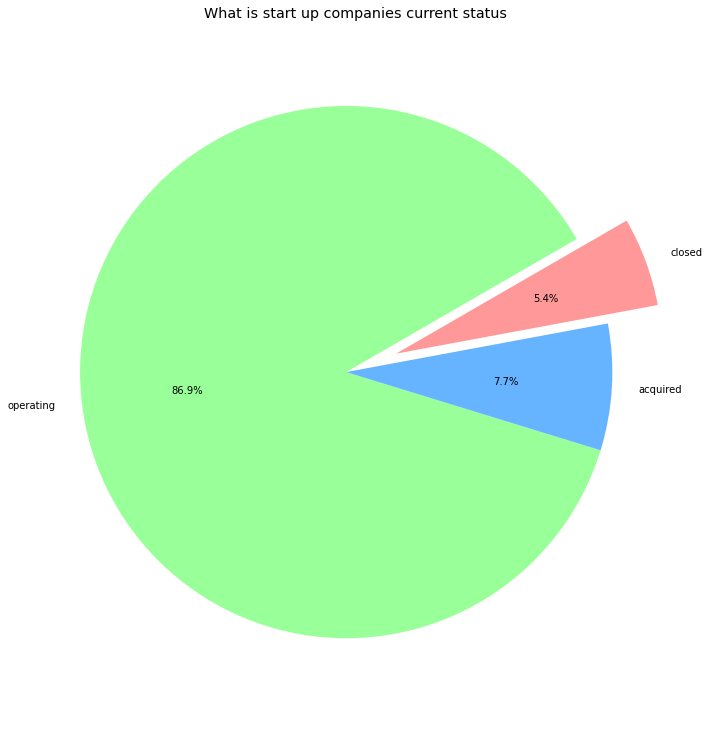

In [15]:
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=30)
plt.axis('equal')
plt.tight_layout()
plt.title("What is start up companies current status", fontdict=None, position= [0.48,1], size = 'x-large')
plt.show()

**Category **
the category shows the class of company for example, software, games, education,etc

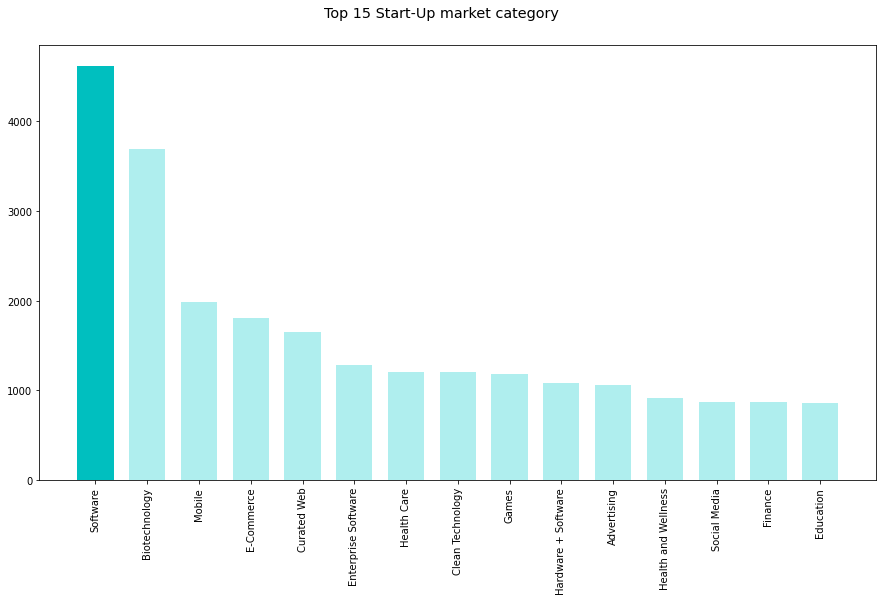

In [16]:
plt.rcParams['figure.figsize'] = 15,8

height = data[odict_keys[0]]['market'].value_counts()[:15].tolist()
bars =  data[odict_keys[0]]['market'].value_counts()[:15].index.tolist()
y_pos = np.arange(len(bars))
plt.bar(y_pos, height , width=0.7 ,color= ['c']+['paleturquoise']*14)
plt.xticks(y_pos, bars)
plt.xticks(rotation=90)
plt.title("Top 15 Start-Up market category", fontdict=None, position= [0.48,1.05], size = 'x-large')
plt.show()

In [0]:
set_keywords = set()
for liste_keywords in  data[odict_keys[0]]['category_list'].str.split('|').values:
    if isinstance(liste_keywords, float): continue  # only happen if liste_keywords = NaN
    set_keywords = set_keywords.union(liste_keywords)
#_________________________
# remove null chain entry
set_keywords.remove('')

In [0]:
data1=data[odict_keys[0]]

In [0]:
keyword_occurences, dum = count_word(data1,'category_list',set_keywords)

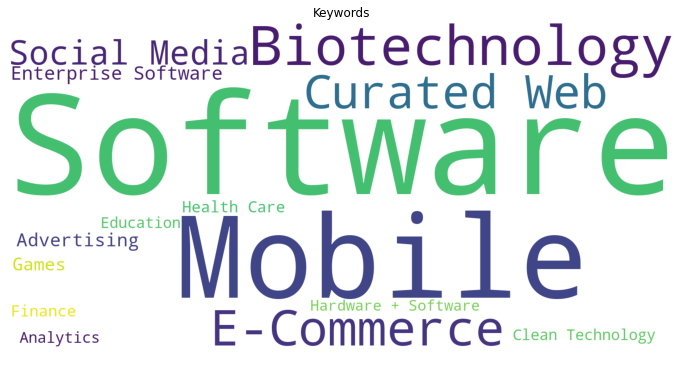

In [20]:
makeCloud(keyword_occurences[0:15],"Keywords","White")


The most popular category is still about Software & Mobile,
It maybe because these 2 categories are easily to scalable ? 

 Total Funding USD

In [21]:
data1['funding_total_usd'].head()


0    1750000
1    4000000
2      40000
3    1500000
4      60000
Name: funding_total_usd, dtype: int64

Unlucky..., this column is provided in "string" format which contain comma(,) minus(-) and space ( )
we need to replace them and convert it to numeric format first


In [0]:
#data1['funding_total_usd'] = data1['funding_total_usd'].str.replace(',', '')
#data1['funding_total_usd'] = data1['funding_total_usd'].str.replace('-', '')
#data1['funding_total_usd'] = data1['funding_total_usd'].str.replace(' ', '')

#data1['funding_total_usd'] = pd.to_numeric(data1['funding_total_usd'], errors='coerce')

Distribution of total

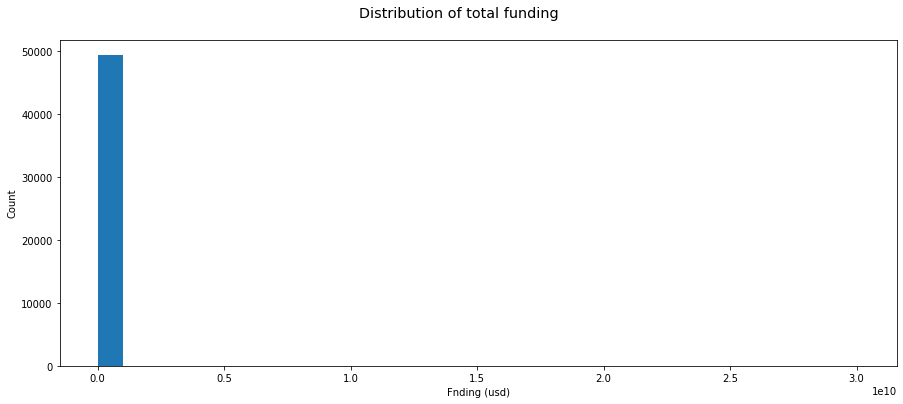

In [23]:
plt.rcParams['figure.figsize'] = 15,6
plt.hist(data1['funding_total_usd'].dropna(), bins=30)
plt.ylabel('Count')
plt.xlabel('Fnding (usd)')
plt.title("Distribution of total funding ", fontdict=None, position= [0.48,1.05], size = 'x-large')
plt.show()

Seem like it has large gap between the highest value and the lowest

In [0]:
Q1 = data1['funding_total_usd'].quantile(0.25)
Q3 = data1['funding_total_usd'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = (Q1 - 1.5 * IQR)
upper_bound = (Q3 + 1.5 * IQR)

In [0]:
without_outlier = data1[(data1['funding_total_usd'] > lower_bound ) & (data1['funding_total_usd'] < upper_bound)]

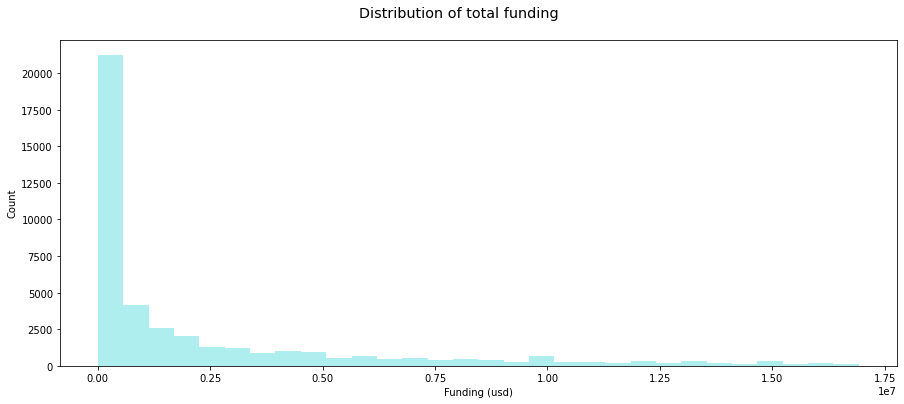

In [26]:
plt.rcParams['figure.figsize'] = 15,6
plt.hist(without_outlier['funding_total_usd'].dropna(), bins=30,color = 'paleturquoise' )

plt.ylabel('Count')
plt.xlabel('Funding (usd)')
plt.title("Distribution of total funding ", fontdict=None, position= [0.48,1.05], size = 'x-large')
plt.show()



The average funding is around 15 m usd.

Let see the position of well-known company like Facebook, Alibaba, Uber but those companies are unicorn startup!!.
Then, we  need to move hist plot to focus only funding >= 1 billion usd

In [0]:
Facebook_total_funding = data1['funding_total_usd'][data1['name']=="Facebook"].values[0]
Uber_total_funding = data1['funding_total_usd'][data1['name']=="Uber"].values[0]
Alibaba_total_funding = data1['funding_total_usd'][data1['name']=="Alibaba"].values[0]
Cloudera_total_funding = data1['funding_total_usd'][data1['name']=="Cloudera"].values[0]

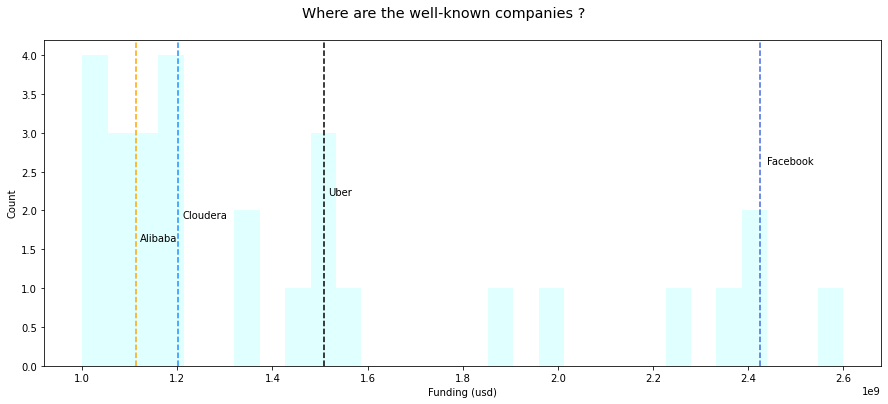

In [28]:
plt.rcParams['figure.figsize'] = 15,6

plt.hist(data1['funding_total_usd'][(data1['funding_total_usd'] >= 1000000000)&(data1['funding_total_usd'] <= 3000000000)].dropna(), bins=30,color = 'lightcyan' )
plt.ylabel('Count')
plt.xlabel('Funding (usd)')
plt.title("Where are the well-known companies ? ", fontdict=None, position= [0.48,1.05], size = 'x-large')

plt.axvline(Facebook_total_funding,color='royalblue',linestyle ="--")
plt.text(Facebook_total_funding+15000000, 2.6,"Facebook")

plt.axvline(Uber_total_funding,color='black',linestyle ="--")
plt.text(Uber_total_funding+10000000, 2.2,"Uber")

plt.axvline(Cloudera_total_funding,color='dodgerblue',linestyle ="--")
plt.text(Cloudera_total_funding+10000000, 1.9,"Cloudera")

plt.axvline(Alibaba_total_funding,color='orange',linestyle ="--")
plt.text(Alibaba_total_funding+10000000, 1.6,"Alibaba")
#plt.ticklabel_format(style='plain')



plt.show()


 Who get the highest funding ?

In [0]:
Verizon_total_funding = data1['funding_total_usd'][data1['name']=="Verizon Communications"].values[0]
Sberbank_total_funding = data1['funding_total_usd'][data1['name']=="Sberbank"].values[0]

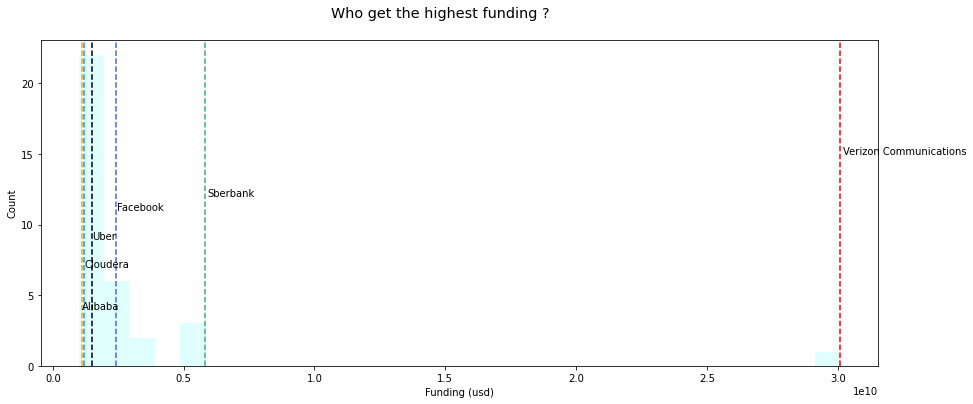

In [30]:
plt.rcParams['figure.figsize'] = 15,6
plt.hist(data1['funding_total_usd'][(data1['funding_total_usd'] >= 1000000000)].dropna(), bins=30,color = 'lightcyan' )
plt.ylabel('Count')
plt.xlabel('Funding (usd)')
plt.title("Who get the highest funding ? ", fontdict=None, position= [0.48,1.05], size = 'x-large')

plt.axvline(Facebook_total_funding,color='royalblue',linestyle ="--")
plt.text(Facebook_total_funding+15000000, 11,"Facebook")

plt.axvline(Uber_total_funding,color='black',linestyle ="--")
plt.text(Uber_total_funding+10000000, 9,"Uber")

plt.axvline(Cloudera_total_funding,color='dodgerblue',linestyle ="--")
plt.text(Cloudera_total_funding+10000000, 7,"Cloudera")

plt.axvline(Alibaba_total_funding,color='orange',linestyle ="--")
plt.text(Alibaba_total_funding+10000000, 4,"Alibaba")

plt.axvline(Verizon_total_funding,color='red',linestyle ="--")
plt.text(Verizon_total_funding+100000000, 15,"Verizon Communications")

plt.axvline(Sberbank_total_funding,color='mediumseagreen',linestyle ="--")
plt.text(Sberbank_total_funding+100000000, 12,"Sberbank")


plt.show()

#  (2) Training  ⚗️



We will model the factors that describe the company status: operating/closed and acquired stage.

---



This column(founded_at) is provided in term of string format which we need to convert to datetime first 

In [31]:
data1['founded_at'].head()

0    2012-06-01 00:00:00
1                    NaN
2    2012-10-26 00:00:00
3    2011-04-01 00:00:00
4    2014-01-01 00:00:00
Name: founded_at, dtype: object

In [0]:
data1['founded_at'] = pd.to_datetime(data1['founded_at'], errors = 'coerce' )

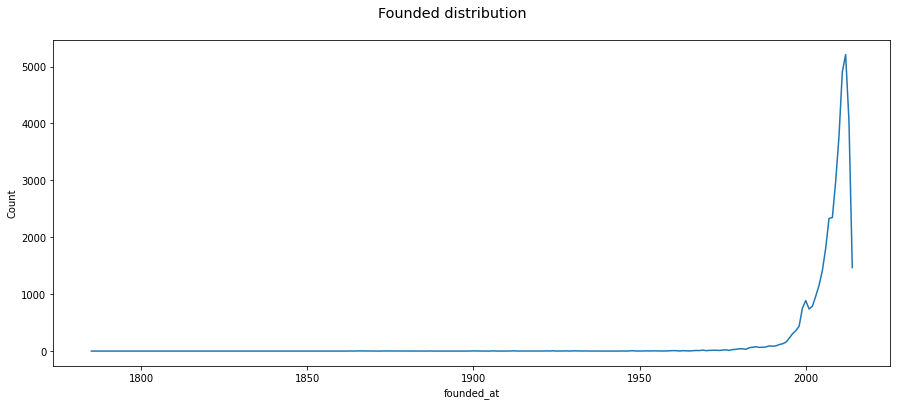

In [33]:
plt.rcParams['figure.figsize'] = 15,6
data1['name'].groupby(data1["founded_at"].dt.year).count().plot(kind="line")

plt.ylabel('Count')
plt.title("Founded distribution ", fontdict=None, position= [0.48,1.05], size = 'x-large')
plt.show()


Founding information 

In [0]:
category=data1['status'].astype('category') # y variable to describe 

In [0]:
data_test_model= data1[['market','funding_total_usd','funding_rounds','status']] #select the variables to the model

In [36]:
data_test_model.head()

,market,funding_total_usd,funding_rounds,status
0,News,1750000,1,acquired
1,Games,4000000,2,operating
2,Publishing,40000,1,operating
3,Electronics,1500000,1,operating
4,Tourism,60000,2,operating


In [0]:
features=data_test_model.replace(np.nan,-9, regex=True) #avoid nan
features['market'] = features['market'].str.replace('|', ' ') #cleaning data 
features['market'] = features['market'].str.replace('+', ' ') #cleaning data 
features['market'] = features['market'].str.replace('&', ' ') #cleaning data 
features['market'] = features['market'].str.replace('>', ' ') #cleaning data 
features['market'] = features['market'].str.replace('<', ' ') #cleaning data 

In [0]:
features['market']=features['market'].astype("string")

In [39]:
features.head()

,market,funding_total_usd,funding_rounds,status
0,News,1750000,1,acquired
1,Games,4000000,2,operating
2,Publishing,40000,1,operating
3,Electronics,1500000,1,operating
4,Tourism,60000,2,operating


In [40]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49438 entries, 0 to 49437
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   market             45470 non-null  string
 1   funding_total_usd  49438 non-null  int64 
 2   funding_rounds     49438 non-null  int64 
 3   status             49438 non-null  object
dtypes: int64(2), object(1), string(1)
memory usage: 1.5+ MB


In [0]:
features= features.drop(['status'], axis = 1)

In [42]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49438 entries, 0 to 49437
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   market             45470 non-null  string
 1   funding_total_usd  49438 non-null  int64 
 2   funding_rounds     49438 non-null  int64 
dtypes: int64(2), string(1)
memory usage: 1.1 MB


Feature engineering

In [0]:
market=pd.get_dummies(features['market'],dummy_na=True)

In [44]:
features.head()

,market,funding_total_usd,funding_rounds
0,News,1750000,1
1,Games,4000000,2
2,Publishing,40000,1
3,Electronics,1500000,1
4,Tourism,60000,2


In [0]:
result = pd.concat([features, market], axis=1, sort=False)

In [0]:
features= result.drop(['market'], axis = 1) #drop  the y values of the model

In [0]:
features=features.fillna(0)

Checking the data is cleaning  🧹

In [48]:
missing_values_table(features)

Your selected dataframe has 756 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [49]:
print('Train columns with null values: \n', features.isnull().sum())
print("-"*10)
print (features.info())
print("-"*10)

print('Test/Validation columns with null values: \n', features.isnull().sum())
print("-"*10)
print (features.info())
print("-"*10)

features.describe(include = 'all')

Train columns with null values: 
 funding_total_usd    0
funding_rounds       0
3D                   0
3D Printing          0
3D Technology        0
                    ..
iPad                 0
iPhone               0
iPod Touch           0
mHealth              0
NaN                  0
Length: 756, dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49438 entries, 0 to 49437
Columns: 756 entries, funding_total_usd to nan
dtypes: int64(2), uint8(754)
memory usage: 36.3 MB
None
----------
Test/Validation columns with null values: 
 funding_total_usd    0
funding_rounds       0
3D                   0
3D Printing          0
3D Technology        0
                    ..
iPad                 0
iPhone               0
iPod Touch           0
mHealth              0
NaN                  0
Length: 756, dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49438 entries, 0 to 49437
Columns: 756 entries, funding_total_usd to nan
dtypes: int64(2), uint8(754)


,funding_total_usd,funding_rounds,3D,3D Printing,3D Technology,Accounting,Ad Targeting,Advanced Materials,Adventure Travel,Advertising,Advertising Exchanges,Advertising Networks,Advertising Platforms,Advice,Aerospace,Agriculture,Algorithms,All Markets,All Students,Alternative Medicine,Alumni,Analytics,Android,Angels,Animal Feed,App Discovery,App Marketing,App Stores,Application Performance Monitoring,Application Platforms,Apps,Architecture,Archiving,Art,Artificial Intelligence,Artists Globally,Assisitive Technology,Auctions,Audio,Augmented Reality,...,Video Games,Video Processing,Video Streaming,Video on Demand,Virtual Currency,Virtual Goods,Virtual Workforces,Virtual Worlds,Virtualization,Visual Search,Visualization,VoIP,Water,Water Purification,Wealth Management,Web Browsers,Web CMS,Web Design,Web Development,Web Hosting,Web Presence Management,Web Tools,WebOS,Weddings,Weird Hardware,Wholesale,Wind,Windows Phone 7,Wine And Spirits,Wireless,Women,World Domination,Writers,Young Adults,iOS,iPad,iPhone,iPod Touch,mHealth,NaN
count,4.943800e+04,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.00000,49438.000000,49438.000000,49438.00000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.00000,49438.000000,49438.000000,49438.000000,49438.00000,49438.00000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.00000,49438.000000,49438.000000,49438.000000,...,49438.000000,49438.00000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.00000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.00000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000,49438.000000
mean,1.318989e+07,1.696205,0.000506,0.000182,0.000162,0.000364,0.000263,0.00004,0.000121,0.021522,0.00004,0.000081,0.000587,0.000263,0.000405,0.000546,0.000101,0.000142,0.000344,0.00004,0.000020,0.012480,0.001841,0.00004,0.00004,0.000020,0.000546,0.000162,0.000101,0.000405,0.005097,0.000162,0.000061,0.000566,0.000485,0.000121,0.00004,0.000526,0.000405,0.000243,...,0.000566,0.00004,0.001274,0.000243,0.000142,0.000061,0.000081,0.000384,0.000546,0.000162,0.000182,0.000607,0.000142,0.000142,0.000101,0.000162,0.000283,0.000485,0.002083,0.009021,0.000020,0.00089,0.000061,0.000384,0.000020,0.000202,0.000020,0.000081,0.000384,0.001537,0.000243,0.000121,0.000020,0.00004,0.000971,0.000587,0.001396,0.000061,0.000162,0.080262
std,1.535801e+08,1.294213,0.022482,0.013491,0.012720,0.019078,0.016214,0.00636,0.011016,0.145118,0.00636,0.008995,0.024213,0.016214,0.020109,0.023363,0.010056,0.011899,0.018541,0.00636,0.004497,0.111017,0.042864,0.00636,0.00636,0.004497,0.023363,0.012720,0.010056,0.020109,0.071214,0.012720,0.007790,0.023792,0.022028,0.011016,0.00636,0.022927,0.020109,0.015578,...,0.023792,0.00636,0.035675,0.015578,0.011899,0.007790,0.008995,0.019601,0.023363,0.012720,0.013491,0.024627,0.011899,0.011899,0.010056,0.012720,0.016826,0.022028,0.045597,0.094553,0.004497,0.02982,0.007790,0.019601,0.004497,0.014221,0.004497,0.008995,0.019601,0.039178,0.015578,0.011016,0.004497,0.00636,0.031145,0.024213,0.037333,0.007790,0.012720,0.271701
min,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [0]:
features['funding_total_usd']=pd.to_numeric(features.funding_total_usd, downcast ='signed')

In [0]:
features['funding_rounds']=pd.to_numeric(features.funding_rounds, downcast ='signed')

Split the data ( 80 trainning . 20% test )

In [0]:
category= (category.cat.codes.replace(-1, np.nan)
               .interpolate().astype(int).astype('category')
               .cat.rename_categories(category.cat.categories))

In [0]:
y = pd.factorize(category)[0]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(features,y, test_size=0.8, random_state=42)

Random Forest Algorithm 

In [0]:
random_forest = RandomForestClassifier(criterion = "gini", 
                                       min_samples_leaf = 1, 
                                       min_samples_split = 10,   
                                       n_estimators=100, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=1, 
                                       n_jobs=-1)


In [0]:
model=random_forest.fit(X_train, y_train)

In [57]:
Y_prediction = model.predict(X_test)
model.score(X_train, y_train)
acc_random_forest = round(model.score(X_train, y_train) * 100, 2)
print("oob score:", round(model.oob_score_, 4)*100, "%")


oob score: 84.65 %


Cross Validation

In [104]:
from sklearn.model_selection import cross_val_score
scores1 = cross_val_score(model, X_train, y_train, cv=5, scoring = "accuracy")
print("Scores:", scores1)
print("Mean:", scores1.mean())
print("Standard Deviation:", scores1.std())

Scores: [0.84277048 0.84529828 0.84876075 0.8442084  0.85128983]
Mean: 0.8464655469138777
Standard Deviation: 0.0031193742905395554


In [106]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, Y_prediction))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, Y_prediction))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, Y_prediction)))


Mean Absolute Error: 0.1448509519354757
Mean Squared Error: 0.1475816034992794
Root Mean Squared Error: 0.3841635114105443


Confusion Matrix

In [62]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
predictions = cross_val_predict(model, X_train, y_train, cv=3)
confusion_matrix(y_train, predictions)

array([[  19,  744,    9],
       [  68, 8352,   70],
       [   7,  599,   19]])

Importance variables from the random-forest model

In [63]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
funding_total_usd,0.525
funding_rounds,0.054
Curated Web,0.022
Public Relations,0.008
Software,0.008
Web Hosting,0.007
Mobile,0.007
Games,0.006
Social Media,0.006


XGBoost

In [107]:

from xgboost import XGBClassifier
model = XGBClassifier()
from sklearn.metrics import accuracy_score
model.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [108]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy_1 = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy_1 * 100.0))

Accuracy: 86.78%


In [0]:
from sklearn.model_selection import KFold

In [0]:
scores2 = cross_val_score(model, X_train, y_train, cv=5, scoring = "accuracy")

In [111]:
print("Scores:", scores2)
print("Mean:", scores2.mean())
print("Standard Deviation:", scores2.std())

Scores: [0.85844287 0.85743175 0.85887709 0.85887709 0.85887709]
Mean: 0.8585011760626374
Standard Deviation: 0.0005605352970207498


In [112]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Mean Absolute Error: 0.1322343303582716
Mean Squared Error: 0.13233546560137543
Root Mean Squared Error: 0.36377941888096893


 Decision Tree

In [69]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
print("Accuracy: %.2f%%" % (test_score * 100.0))

Accuracy: 86.75%


In [0]:
 scores3 = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5, scoring = "accuracy")

In [72]:
print("Scores:", scores3)
print("Mean:", scores3.mean())
print("Standard Deviation:", scores3.std())

Scores: [0.85844287 0.85844287 0.85887709 0.85887709 0.85887709]
Mean: 0.8587034005317982
Standard Deviation: 0.00021272099228313756


In [0]:
y_predict=clf.predict(X_test)

In [116]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))


Mean Absolute Error: 0.13284114181689463
Mean Squared Error: 0.13359965614017344
Root Mean Squared Error: 0.36551286727032395


Deep Learning



Refacturing data 

In [0]:
from sklearn.preprocessing import LabelEncoder
encoder =  LabelEncoder()
y1 = encoder.fit_transform(y)
Y = pd.get_dummies(y1).values


In [0]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest, ytrain,ytest = train_test_split(features,Y,test_size=0.2,random_state=0) 

In [121]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD,Adam
model = Sequential()

model.add(Dense(10,input_shape=(756,),activation='tanh')) #number of the parameters from X
model.add(Dense(8,activation='tanh'))
model.add(Dense(6,activation='tanh'))
model.add(Dense(3,activation='softmax'))

model.compile(Adam(lr=0.04),'categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                7570      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 21        
Total params: 7,733
Trainable params: 7,733
Non-trainable params: 0
_________________________________________________________________


fitting the model and predicting  

In [122]:
model.fit(Xtrain,ytrain,epochs=100)

Epoch 1/100
39550/39550 [==============================] - 3s 66us/step - loss: 0.4923 - accuracy: 0.8662
Epoch 2/100
39550/39550 [==============================] - 3s 63us/step - loss: 0.4890 - accuracy: 0.8676
Epoch 3/100
39550/39550 [==============================] - 2s 63us/step - loss: 0.4891 - accuracy: 0.8676
Epoch 4/100
39550/39550 [==============================] - 3s 63us/step - loss: 0.4892 - accuracy: 0.8676
Epoch 5/100
39550/39550 [==============================] - 2s 62us/step - loss: 0.4898 - accuracy: 0.8676
Epoch 6/100
39550/39550 [==============================] - 2s 61us/step - loss: 0.4894 - accuracy: 0.8676
Epoch 7/100
39550/39550 [==============================] - 2s 62us/step - loss: 0.4896 - accuracy: 0.8676
Epoch 8/100
39550/39550 [==============================] - 2s 61us/step - loss: 0.4880 - accuracy: 0.8676
Epoch 9/100
39550/39550 [==============================] - 2s 62us/step - loss: 0.4912 - accuracy: 0.8676
Epoch 10/100
39550/39550 [====================

In [0]:
y_pred = model.predict(Xtest)
y_test_class = np.argmax(ytest,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

In [124]:
print('Mean Absolute Error:', metrics.mean_absolute_error(ytest, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(ytest, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytest, y_pred)))


Mean Absolute Error: 0.17555654
Mean Squared Error: 0.08329176
Root Mean Squared Error: 0.28860313


Accuracy of the predicted values

In [78]:

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.17      0.00      0.00       802
           1       0.86      1.00      0.93      8511
           2       0.00      0.00      0.00       575

    accuracy                           0.86      9888
   macro avg       0.34      0.33      0.31      9888
weighted avg       0.75      0.86      0.80      9888

[[   1  801    0]
 [   3 8508    0]
 [   2  573    0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# (3) Model comparison 🏆

We try to run 10 fold cross-validation to validate our model. This step is usually skipped in CNN's because of the computational overhead

Model 1 :Random Forest Algorithm 

In [93]:
print("Scores:", scores1)
print("Mean:", scores1.mean())
print("Standard Deviation:", scores1 .std())

Scores: [0.84277048 0.84529828 0.84876075 0.8442084  0.85128983]
Mean: 0.8464655469138777
Standard Deviation: 0.0031193742905395554


This implementation gives a mean accuracy of 84.6% with a standard deviation of 0.03%

Mean Absolute Error: 0.1448509519354757
Mean Squared Error: 0.1475816034992794
Root Mean Squared Error: 0.3841635114105443

Model 2 : XGBoost


In [94]:
print("Scores:", scores2)
print("Mean:", scores2.mean())
print("Standard Deviation:", scores2 .std())

Scores: [0.85844287 0.85743175 0.85887709 0.85887709 0.85887709]
Mean: 0.8585011760626374
Standard Deviation: 0.0005605352970207498


This implementation gives a mean accuracy of 85.8% with a standard deviation of 0.005%

Mean Absolute Error: 0.1322343303582716
Mean Squared Error: 0.13233546560137543
Root Mean Squared Error: 0.36377941888096893

Model 3: Decision Tree

In [95]:
print("Scores:", scores3)
print("Mean:", scores3.mean())
print("Standard Deviation:", scores3 .std())

Scores: [0.85844287 0.85844287 0.85887709 0.85887709 0.85887709]
Mean: 0.8587034005317982
Standard Deviation: 0.00021272099228313756


This implementation gives a mean accuracy of 85.8% with a standard deviation of 0.002%

Mean Absolute Error: 0.13284114181689463
Mean Squared Error: 0.13359965614017344
Root Mean Squared Error: 0.36551286727032395

Model 4: Keras.Sequential

In [96]:
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.17      0.00      0.00       802
           1       0.86      1.00      0.93      8511
           2       0.00      0.00      0.00       575

    accuracy                           0.86      9888
   macro avg       0.34      0.33      0.31      9888
weighted avg       0.75      0.86      0.80      9888

[[   1  801    0]
 [   3 8508    0]
 [   2  573    0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This implementation gives a mean accuracy of 86%

Mean Absolute Error: 0.17555654
Mean Squared Error: 0.08329176
Root Mean Squared Error: 0.28860313